# Import modules

In [1]:
from netCDF4 import Dataset as NetCDFFile
import xarray as xr
import numpy as np
#import matplotlib
from mpl_toolkits.basemap import Basemap, cm

#import glob
#from datetime import datetime
#from wrf import getvar, ALL_TIMES
#import netCDF4 as nc
#import glob
#from datetime import datetime
#import shapefile
#from matplotlib.path import Path
#from matplotlib.patches import PathPatch
#from shapely.geometry import Polygon, Point
#import numpy.ma as ma
#import scipy
#import scipy.stats as stats
from matplotlib import pyplot as plt
#import pandas as pd
#import pytz
from sklearn.cluster import KMeans
import tslearn
from tslearn.clustering import TimeSeriesKMeans as TimeSeriesKMeans

# Load in data

In [2]:
daily_precipitation=xr.open_dataset('/data/PeruGROWS/analysis_data/daily_precip.nc')
lats=xr.open_dataset('/data/PeruGROWS/analysis_data/inner_dom_lats.nc')
lons=xr.open_dataset('/data/PeruGROWS/analysis_data/inner_dom_lats.nc')

#test plot first timestep: plt.contourf(lats.XLAT.values,lons.XLONG.values,daily_precipitation.RAINNC.values[0])

# Sort out data
first, flatten the precipitation, lats and lons data

In [3]:
#precip_flat=daily_precipitation.stack(z=('south_north','west_east')).RAINNC.values
# note to self: this is the same as precip_flat2=daily_precipitation.RAINNC.values.reshape(len(daily_precipitation.RAINNC),93*87)
precip_flat=daily_precipitation.RAINNC.values[:,1:-1,1:-1].reshape(len(daily_precipitation.RAINNC),91*85)

# Start with the simplest-looking clustering algorithm to get an idea
### Investigations with kmeans-start with python own version (also another version that's not quite the same on https://blog.newrelic.com/product-news/optimizing-k-means-clustering/ see initial practice script)

In [4]:
precip_km = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=1000,random_state=0)
clusters=precip_km.fit_predict(precip_flat.transpose())

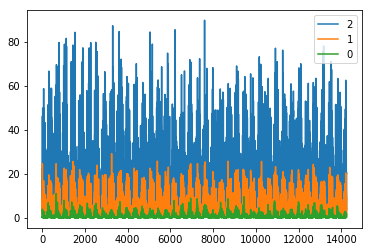

In [43]:
plt.plot(np.flip(np.sort(precip_km.cluster_centers_[:,:,0],axis=0)).transpose())
plt.legend(np.arange(2,-1,-1).astype(str))

## plotting

In [44]:
filename='/data/PeruGROWS/finishedWRFruns/run2015/wrfoutfiles/wrfout_compact_d02.nc'

#no precip at all at boundaries which is causing trouble so do everything from 1 to -1

def plotsetup(filename):
    nc = NetCDFFile(filename, 'r')
    lon=nc.variables['XLONG'][0,1:-1,1:-1]
    lat=nc.variables['XLAT'][0,1:-1,1:-1]
    hgt=nc.variables['HGT'][0,1:-1,1:-1]
    landuse=nc.variables['LU_INDEX'][0,1:-1,1:-1]
    goodvalues=np.array([24,20])
    snowice=np.in1d(landuse.ravel(),goodvalues).reshape(landuse.shape).astype(int)[:,:]
    snowclevs=np.arange(0,1.1,1)
    x_dim = len(nc.dimensions['west_east'])-2
    y_dim = len(nc.dimensions['south_north'])-2
    dx = float(nc.DX)
    dy = float(nc.DY)
    width_meters  = dx * (x_dim - 1)
    height_meters = dy * (y_dim - 1)
    cen_lat  = float(nc.CEN_LAT)
    cen_lon  = float(nc.CEN_LON)
    truelat1 = float(nc.TRUELAT1)
    truelat2 = float(nc.TRUELAT2)
    standlon = float(nc.STAND_LON)
    m = Basemap(resolution='i',area_thresh=10000,projection='merc', llcrnrlat=lat[0,0],urcrnrlat=lat[-1,-1],llcrnrlon=lon[0,0],urcrnrlon=lon[-1,-1],lat_ts=truelat1) #CHECK lat_ts
    lons, lats = m.makegrid(x_dim, y_dim)
    x, y = m(lons, lats)
    parallels = np.arange(-90,0,1)
    meridians = np.arange(0.,360.,1)
    clevs=np.arange(0,6000,500)
    return(x,y,hgt,snowice,snowclevs,m,parallels,meridians,clevs)

(x,y,hgt,snowice,snowclevs,m,parallels,meridians,clevs)=plotsetup(filename)


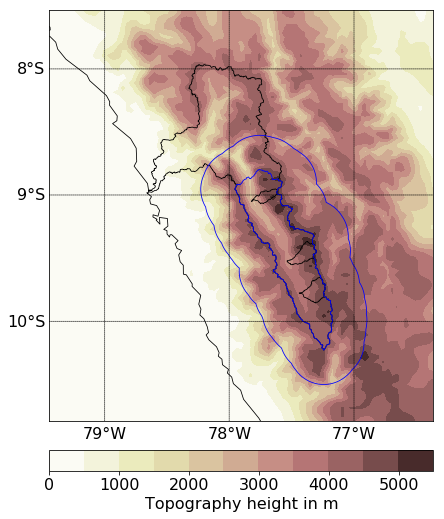

In [45]:

def plotvar(x,y,var,clevs,parallels,meridians,m):
    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_axes([0.1,0.1,0.8,0.8])
    m.readshapefile('/data/hpcdata/users/empott15/PeruGROWS/shapefile_fromINAIGEM/shapefile2/Area_CSanta_INAIGEM_project','RioSanta',linewidth=0.8)
    m.readshapefile('/data/hpcdata/users/empott15/PeruGROWS/shapefile_fromINAIGEM/shapefile2/upper_catchment','RioSanta_upper',linewidth=0.8,color='b')
    m.readshapefile('/data/hpcdata/users/empott15/PeruGROWS/shapefile_fromINAIGEM/shapefile2/upper_catchment_buffer30km','RioSanta_upper',linewidth=0.8,color='b')
    cs = m.contourf(x,y,var,clevs,cmap=plt.cm.pink_r)
    m.drawparallels(parallels,labels=[1,0,0,0],fontsize=16)
    m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=16)
    m.drawcoastlines(linewidth=0.8)
    m.drawcountries(linewidth=0.8)
    cbar = m.colorbar(cs,location='bottom',pad="7%")
    cbar.ax.tick_params(labelsize=16)
    cbar.set_label('Topography height in m',fontsize=16)
    return fig,ax,m

plotvar(x,y,hgt,clevs,parallels,meridians,m)
plt.show()



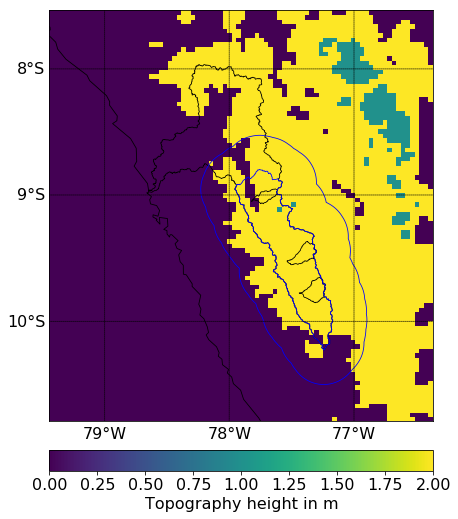

In [46]:

def plotclusters(x,y,precip_clusters,parallels,meridians,m):
    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_axes([0.1,0.1,0.8,0.8])
    m.readshapefile('/data/hpcdata/users/empott15/PeruGROWS/shapefile_fromINAIGEM/shapefile2/Area_CSanta_INAIGEM_project','RioSanta',linewidth=0.8)
    m.readshapefile('/data/hpcdata/users/empott15/PeruGROWS/shapefile_fromINAIGEM/shapefile2/upper_catchment','RioSanta_upper',linewidth=0.8,color='b')
    m.readshapefile('/data/hpcdata/users/empott15/PeruGROWS/shapefile_fromINAIGEM/shapefile2/upper_catchment_buffer30km','RioSanta_upper',linewidth=0.8,color='b')
    cs = m.pcolormesh(x,y,np.reshape(precip_clusters,np.shape(x)))
    m.drawparallels(parallels,labels=[1,0,0,0],fontsize=16)
    m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=16)
    m.drawcoastlines(linewidth=0.8)
    m.drawcountries(linewidth=0.8)
    cbar = m.colorbar(cs,location='bottom',pad="7%")
    cbar.ax.tick_params(labelsize=16)
    cbar.set_label('Topography height in m',fontsize=16)
    return fig,ax,m

plotclusters(x,y,clusters,parallels,meridians,m)
plt.show()



In [6]:

def createandplotkmeanclusters(no_clusters,metric,precip_flat):
    precip_km = TimeSeriesKMeans(n_clusters=no_clusters, metric=metric, max_iter=1000,random_state=0)
    clusters=precip_km.fit_predict(precip_flat.transpose())
    for i in range(len(precip_km.cluster_centers_[:,0,0])):
        plt.plot(precip_km.cluster_centers_[i,:,0])
        plt.title('cluster mean '+str(i))
        plt.show()
    plotclusters(x,y,clusters,parallels,meridians,m)
    plt.title('clusters')
    plt.show()

def createandplotclustersonly(no_clusters,metric,precip_flat):
    precip_km = TimeSeriesKMeans(n_clusters=no_clusters, metric=metric, max_iter=1000,random_state=0)
    clusters=precip_km.fit_predict(precip_flat.transpose())
    plotclusters(x,y,clusters,parallels,meridians,m)
    plt.title('clusters')
    plt.show()

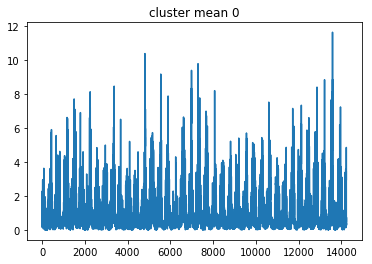

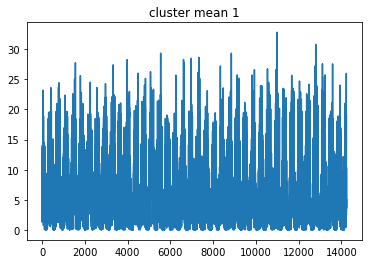

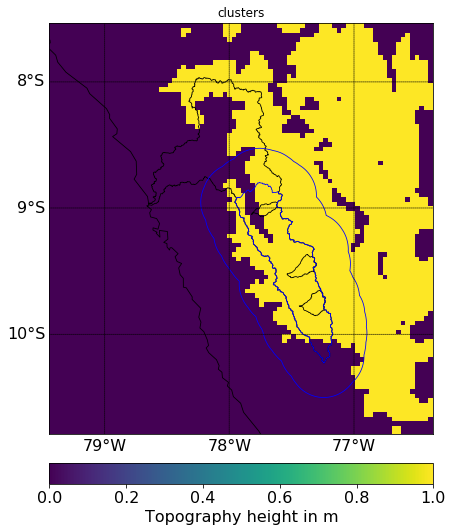

In [151]:
createandplotkmeanclusters(2,'euclidean',precip_flat)

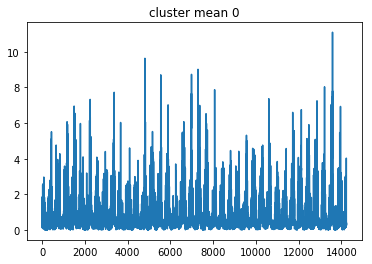

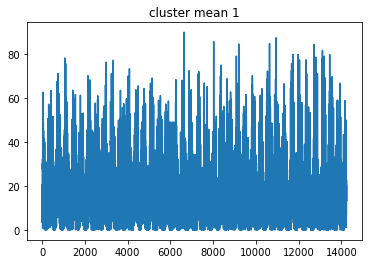

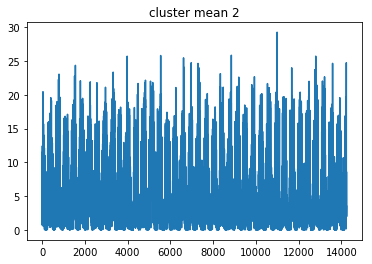

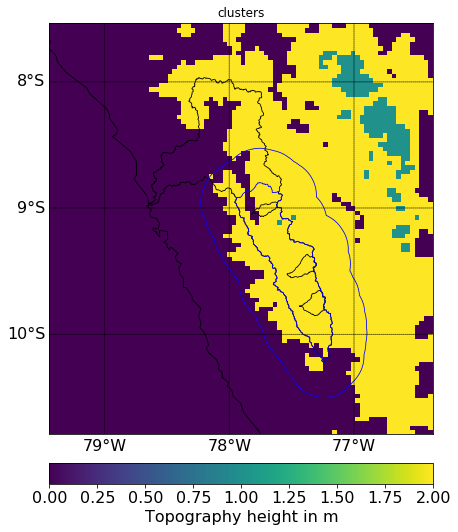

In [152]:
createandplotkmeanclusters(3,'euclidean',precip_flat)

In [1]:
createandplotkmeanclusters(4,'euclidean',precip_flat) 

NameError: name 'createandplotkmeanclusters' is not defined

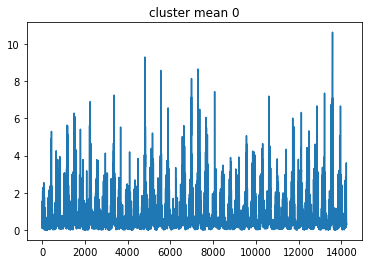

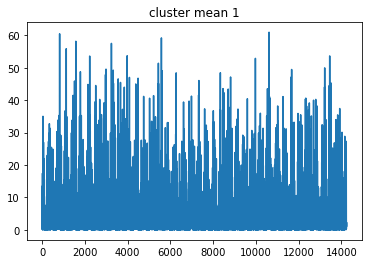

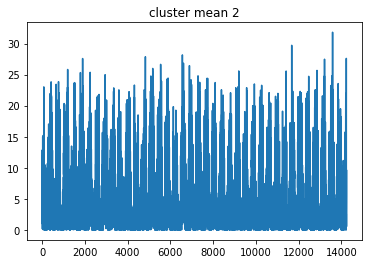

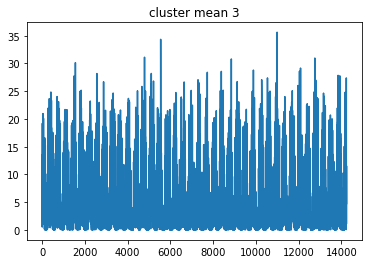

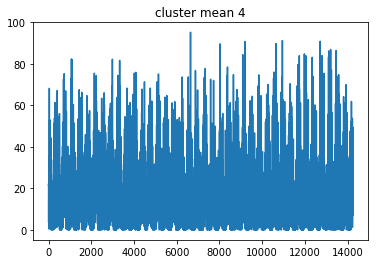

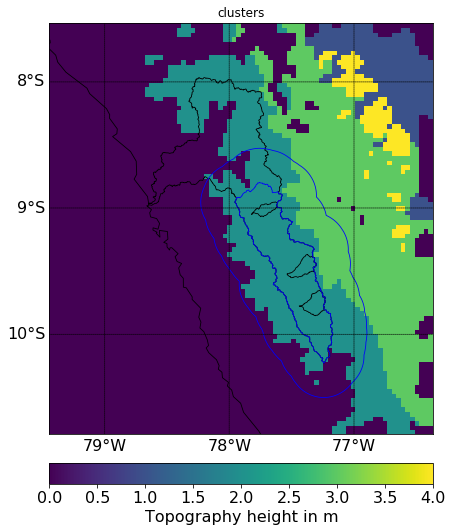

In [158]:
createandplotkmeanclusters(5,'euclidean',precip_flat)

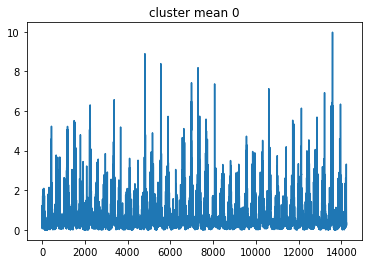

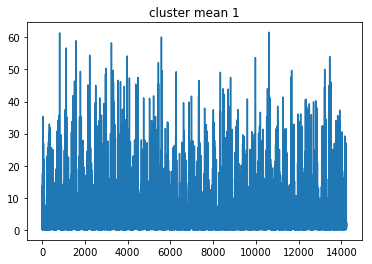

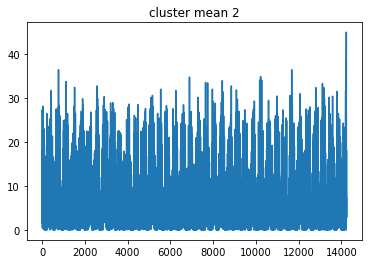

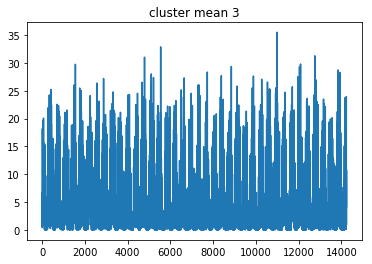

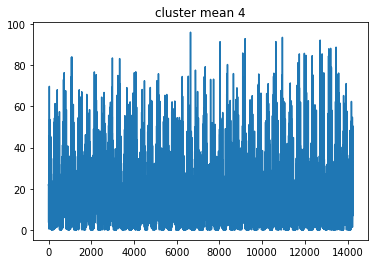

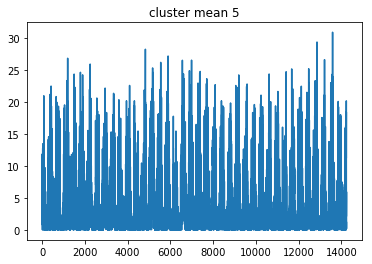

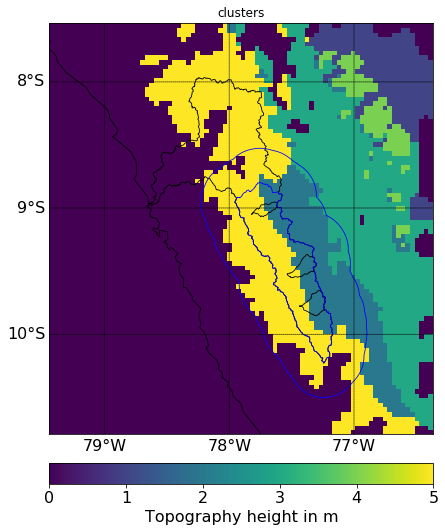

In [155]:
createandplotkmeanclusters(6,'euclidean',precip_flat)

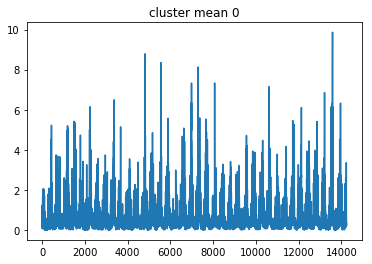

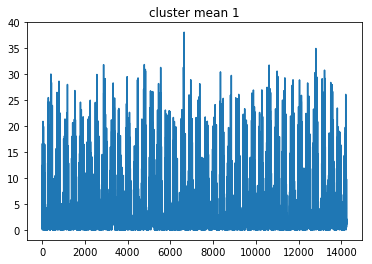

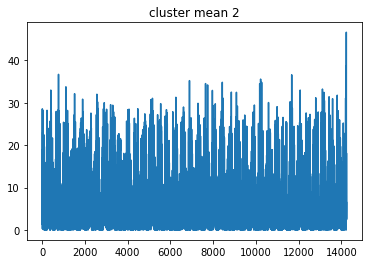

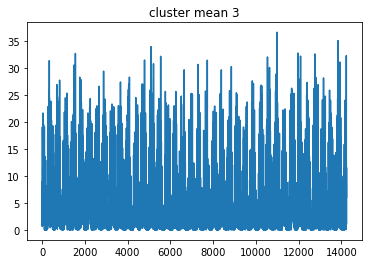

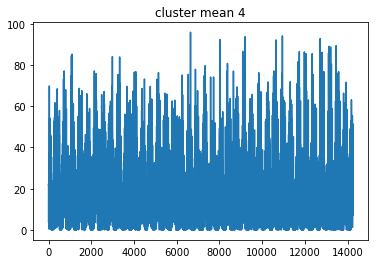

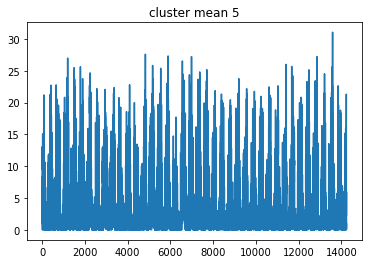

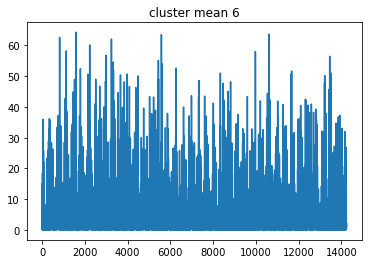

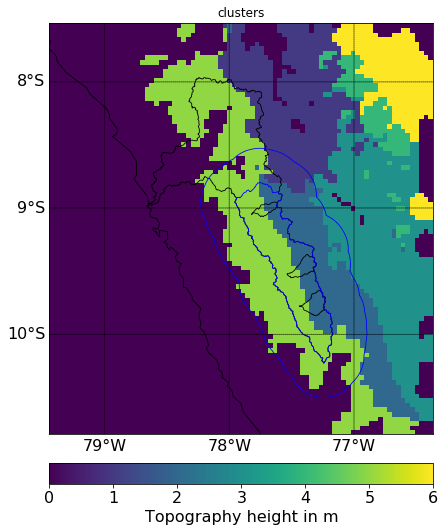

In [156]:
createandplotkmeanclusters(7,'euclidean',precip_flat)

### Maybe need to do some sort of normalisation process so we're not just measuring quantities, but patterns?

In [60]:
daily_precip_norm=daily_precipitation.RAINNC.values[:,1:-1,1:-1]/np.tile(np.mean(daily_precipitation.RAINNC.values[:,1:-1,1:-1],axis=0),(14245,1,1))
precip_flat_norm=daily_precip_norm.reshape(len(daily_precip_norm),91*85)

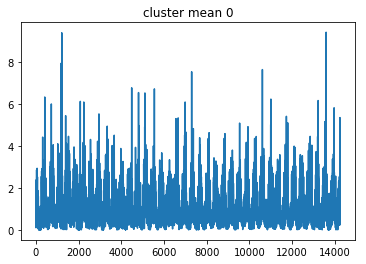

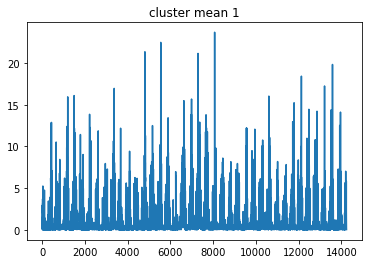

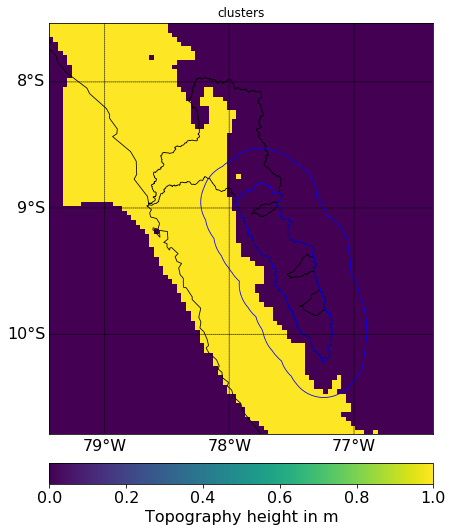

In [159]:
createandplotkmeanclusters(2,'euclidean',precip_flat_norm)

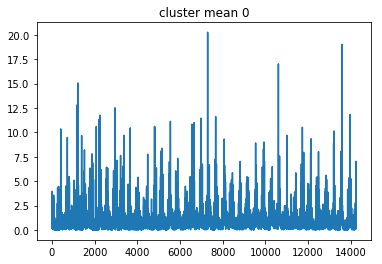

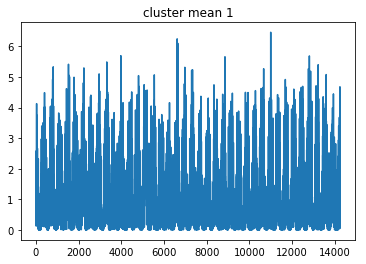

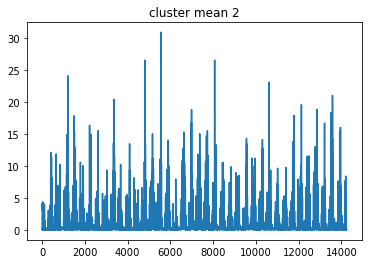

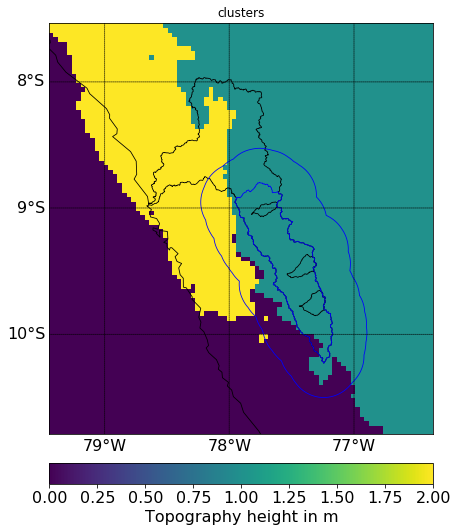

In [160]:
createandplotkmeanclusters(3,'euclidean',precip_flat_norm)

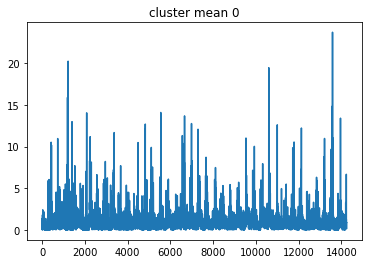

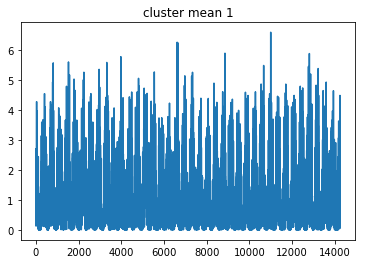

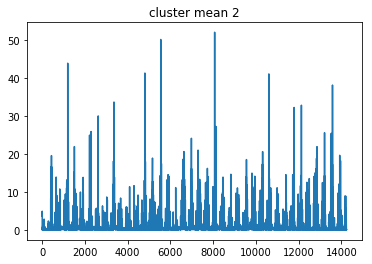

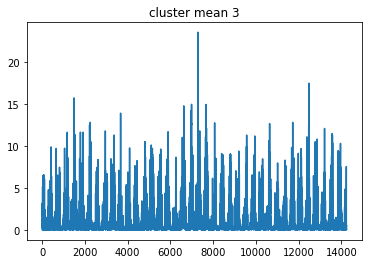

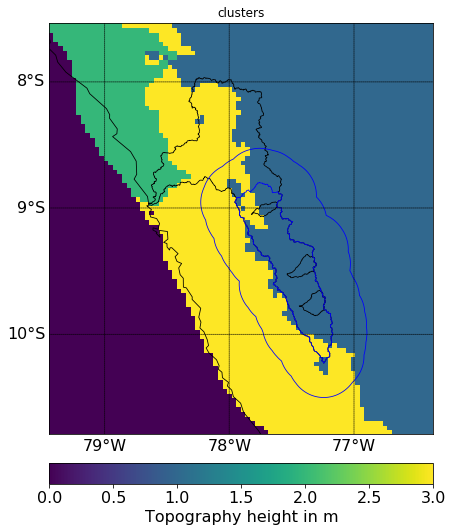

In [161]:
createandplotkmeanclusters(4,'euclidean',precip_flat_norm)

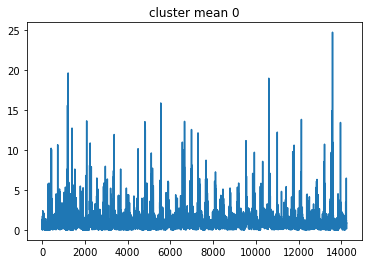

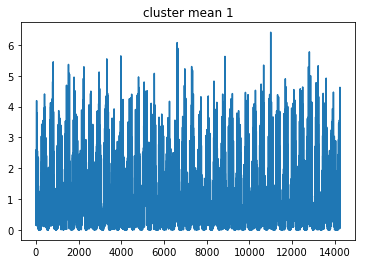

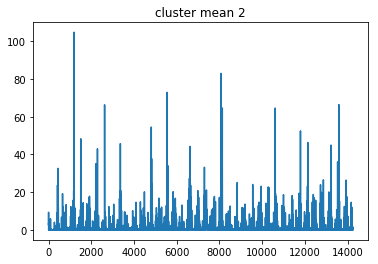

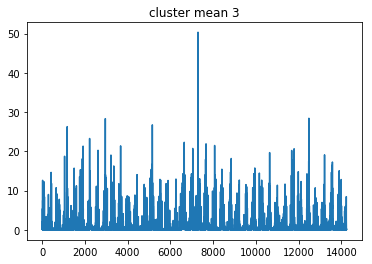

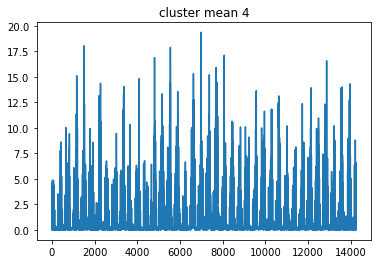

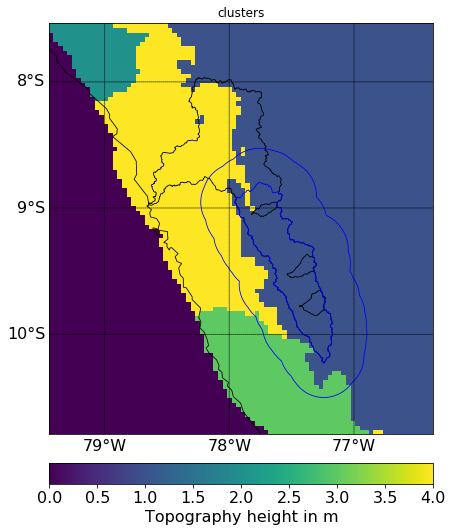

In [162]:
createandplotkmeanclusters(5,'euclidean',precip_flat_norm)

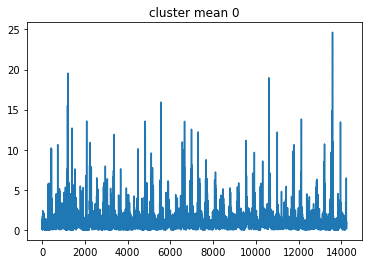

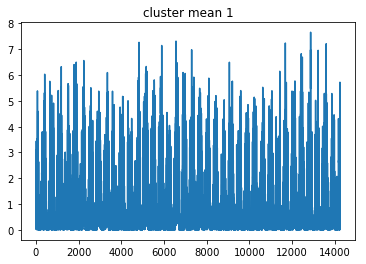

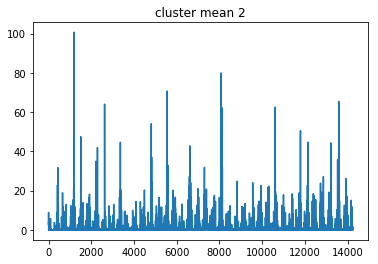

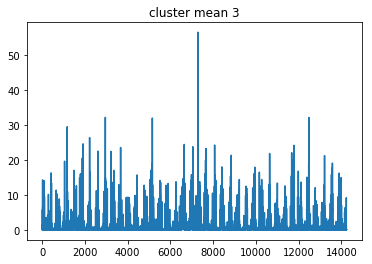

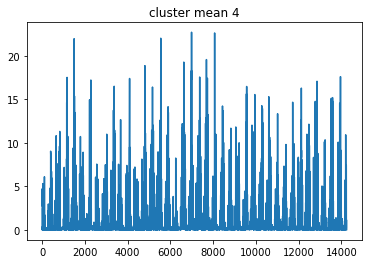

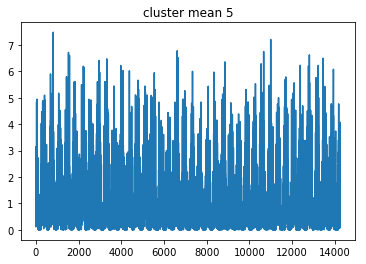

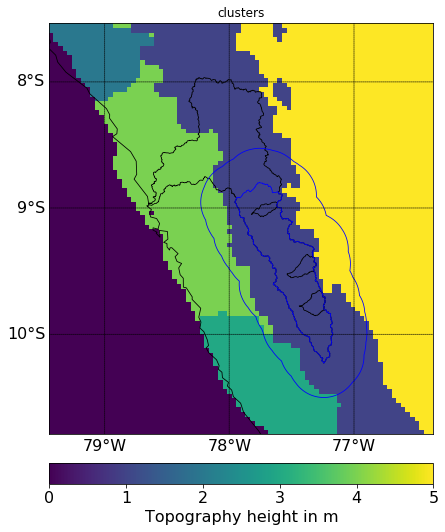

In [163]:
createandplotkmeanclusters(6,'euclidean',precip_flat_norm)

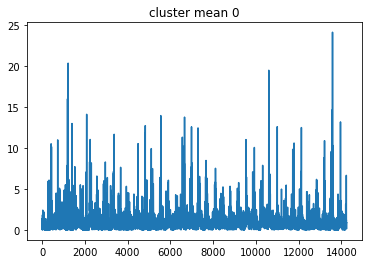

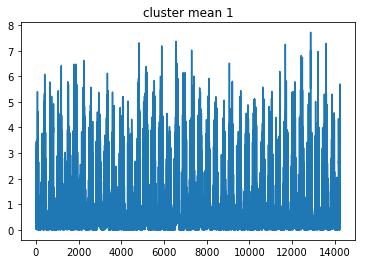

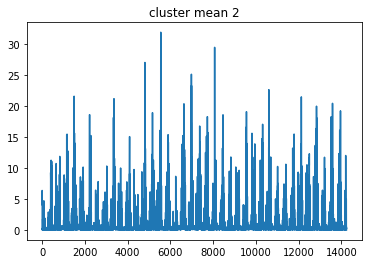

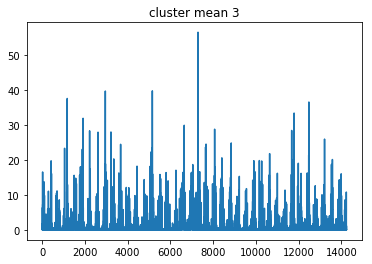

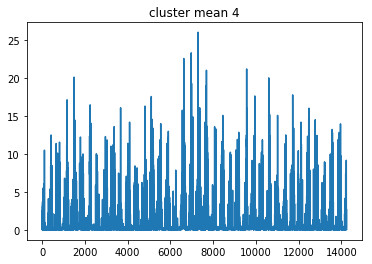

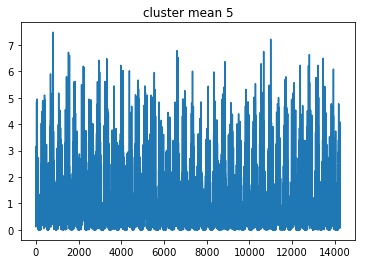

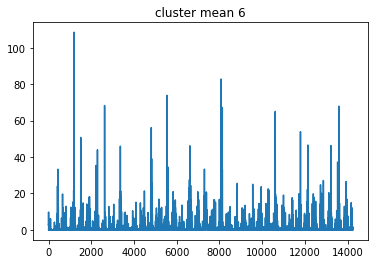

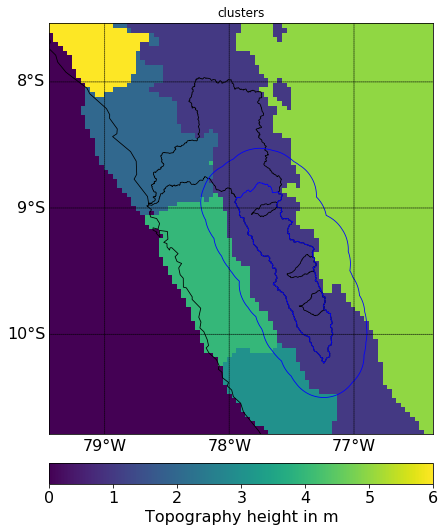

In [164]:
createandplotkmeanclusters(7,'euclidean',precip_flat_norm)

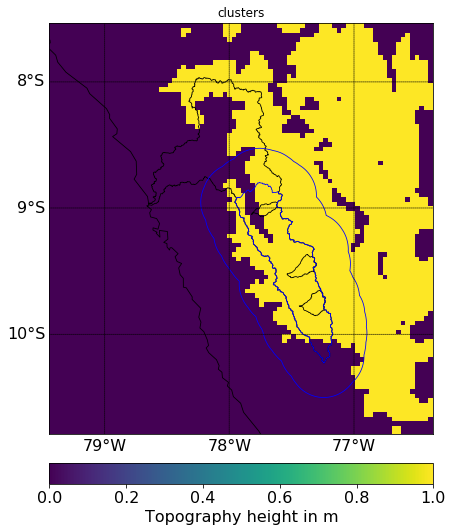

In [166]:
createandplotclustersonly(2,'euclidean',precip_flat_) #dtw is "dynamic time warping" means that it can adjust for speed. this porbably isn't very useful/necessary?

In [ ]:
createandplotclustersonly(2,'dtw',precip_flat) #this seems too slow, can't get it to run

In [ ]:
createandplotclustersonly(2,'softdtw',precip_flat) #this seems too slow, can't get it to run

In [ ]:
createandplotclustersonly(2,'dtw',precip_flat_norm)

## Guassian mixture models attempts

In [ ]:
from sklearn.mixture import GMM
#didn't get very far with these! Will try again if we think it's important?